# Objective: Convolutional Neural Network Classification Using CIFAR-10
Here, I'm going to build an convolutional neural network classification model using PyTorch using CIFAR-10 training data set.

## Import Libraries

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Load Data
This covers how to download the data and load the data into the code.

In [2]:
# load train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

100.0%


Extracting ./cifar-10-python.tar.gz to .


In [5]:
# analyze train dataset
train_dataset.data.shape
set(train_dataset.targets)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [8]:
# load test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

Files already downloaded and verified


In [9]:
# analyze test dataset
test_dataset.data.shape

(10000, 32, 32, 3)

## Preprocess Data
This covers how to create batch using DataLoader.

In [11]:
# get the number of classes
K = len(set(train_dataset.targets))
print(f"The number of classes: {K}")

The number of classes: 10


In [13]:
# dataloader to automatically generate batches in the training loop with shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [15]:
# check whether the dataloader works okay or not
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=1,
                                         shuffle=True)
for x, y in tmp_loader:
    print(x)
    print(x.shape)
    # [batch_size, num_channels, image_height, image_width]
    break

tensor([[[[0.4157, 0.4157, 0.4235,  ..., 0.1569, 0.1333, 0.1176],
          [0.4627, 0.4588, 0.4784,  ..., 0.1412, 0.1255, 0.1216],
          [0.5294, 0.5216, 0.5176,  ..., 0.1451, 0.1255, 0.1216],
          ...,
          [0.7961, 0.8196, 0.8471,  ..., 0.9451, 0.9412, 0.9333],
          [0.8078, 0.8353, 0.8627,  ..., 0.9098, 0.9137, 0.8941],
          [0.8510, 0.8549, 0.8784,  ..., 0.9098, 0.8980, 0.8824]],

         [[0.3608, 0.3569, 0.3608,  ..., 0.0784, 0.0667, 0.0627],
          [0.4000, 0.3922, 0.4078,  ..., 0.0824, 0.0667, 0.0627],
          [0.4549, 0.4431, 0.4392,  ..., 0.0824, 0.0667, 0.0667],
          ...,
          [0.7412, 0.7725, 0.8078,  ..., 0.9529, 0.9412, 0.9294],
          [0.7529, 0.7882, 0.8235,  ..., 0.9137, 0.9020, 0.8784],
          [0.7961, 0.8118, 0.8392,  ..., 0.9098, 0.8863, 0.8588]],

         [[0.2980, 0.2824, 0.2745,  ..., 0.0667, 0.0471, 0.0392],
          [0.3373, 0.3176, 0.3216,  ..., 0.0627, 0.0471, 0.0431],
          [0.3922, 0.3647, 0.3490,  ..., 0

## Build Model
This covers how to build a convolutional neural network classification model using fashion MNIST dataset to train. Since the dataset is big enough, we can use GPU for faster process if available.

In [16]:
# define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        
        # define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)
        # H_out = floor[(H_in + 2*p - d(k-1) - 1)/2 + 1]
        # image size: 32X32 -> 15X15
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        # image size: 15X15 -> 7X7
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        # image size: 7X7 -> 3X3
        
        # define linear (fc) layers
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, K)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.relu(self.conv3(X))
        X = X.view(-1, 128 * 3 * 3)
        X = F.dropout(X, p=0.5)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.2)
        return self.fc2(X)

In [17]:
# instantiate the model
model = CNN(K)

In [18]:
# activate gpu if possible, otherwise cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# send the model to the device
model.to(device)


cuda:0


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [19]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Training
This covers how to train the convolutional neural network classification model with the input data that we processed.

In [20]:
# build a function for training using batch gradient descent
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    # losses will be stored to plot the results
    # storage for losses per each epoch
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        # train mode
        model.train()
        t0 = datetime.now()
        train_loss = []
        
        for inputs, targets in train_loader:
            # send data to the device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # zero the parameter gradients to make sure they are zero
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # backward and optimize
            loss.backward()
            optimizer.step()
            
            # save the batch loss
            train_loss.append(loss.item())
        
        # get train loss per epoch as average loss of all the batches in that epoch
        train_loss = np.mean(train_loss)
        train_losses[epoch] = train_loss
        
        # test mode
        model.eval()
        test_loss = []
        
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        test_losses[epoch] = test_loss
        
        # calculate time spent
        dt = datetime.now() - t0
        
        # print out the result
        print(f"Epoch: {epoch+1}/{epochs}, Train loss: {train_loss:.4f}, Tess loss: {test_loss:.4f}, Duration: {dt}")
    
    return train_losses, test_losses

In [21]:
# get the result
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15
)

Epoch: 1/15, Train loss: 1.7088, Tess loss: 1.4788, Duration: 0:00:04.626322
Epoch: 2/15, Train loss: 1.4279, Tess loss: 1.3611, Duration: 0:00:04.414256
Epoch: 3/15, Train loss: 1.3142, Tess loss: 1.2959, Duration: 0:00:04.371338
Epoch: 4/15, Train loss: 1.2275, Tess loss: 1.2208, Duration: 0:00:04.422208
Epoch: 5/15, Train loss: 1.1524, Tess loss: 1.2062, Duration: 0:00:04.395136
Epoch: 6/15, Train loss: 1.0893, Tess loss: 1.1587, Duration: 0:00:04.391129
Epoch: 7/15, Train loss: 1.0438, Tess loss: 1.0987, Duration: 0:00:04.427965
Epoch: 8/15, Train loss: 0.9899, Tess loss: 1.1109, Duration: 0:00:04.456747
Epoch: 9/15, Train loss: 0.9589, Tess loss: 1.1164, Duration: 0:00:04.523272
Epoch: 10/15, Train loss: 0.9174, Tess loss: 1.0512, Duration: 0:00:04.558174
Epoch: 11/15, Train loss: 0.8824, Tess loss: 1.0364, Duration: 0:00:04.379487
Epoch: 12/15, Train loss: 0.8552, Tess loss: 1.0327, Duration: 0:00:04.529529
Epoch: 13/15, Train loss: 0.8264, Tess loss: 1.0356, Duration: 0:00:04.45

## Result
This shows the result of the convolutional neural network classification model by showing the loss evolution and calculating the accuracy of the model.

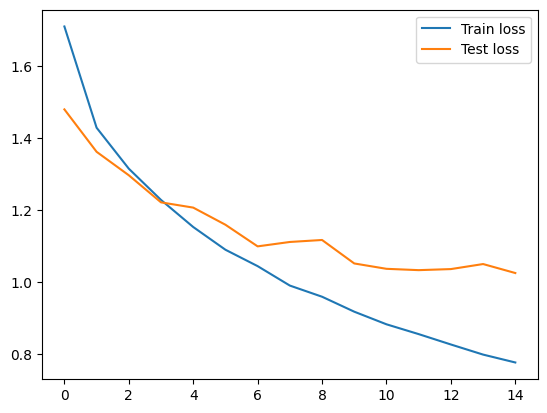

In [23]:
# plot the train loss and test loss per iteration
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [24]:
# calculate accuracy
# train accuracy
n_correct = 0.
n_total = 0.

model.eval()
for inputs, targets in train_loader:
    # send data to the device
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # predictions by returning max value label
    _, predictions = torch.max(outputs, 1)
    
    # update numbers
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

# calculate train accuracy
train_acc = n_correct / n_total

# test accuracy
n_correct = 0.
n_total = 0.

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

# calculate test accuracy
test_acc = n_correct / n_total

# print the result
print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")

Train accuracy: 0.7383, Test accuracy: 0.6422


## Apendix: Confusion Matrix
This covers how to plot confusion matrix using the results that we got above.

In [25]:
# import libraries to plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[677  19  56  30  19  11  15  18 110  45]
 [ 24 714  11  15   4   7  10   8  58 149]
 [ 79   6 542  71  89  67  80  35  20  11]
 [ 37   6  84 395  80 215  90  51  16  26]
 [ 28   1  99  47 572  60  99  79  12   3]
 [ 23   3  76 156  62 564  47  57   5   7]
 [ 11   5  41  48  48  32 787   8   9  11]
 [ 18   4  33  40  86  83  16 698   5  17]
 [ 84  31  23  20   9  12   9  13 769  30]
 [ 42  74  14  29  10  18  15  23  49 726]]


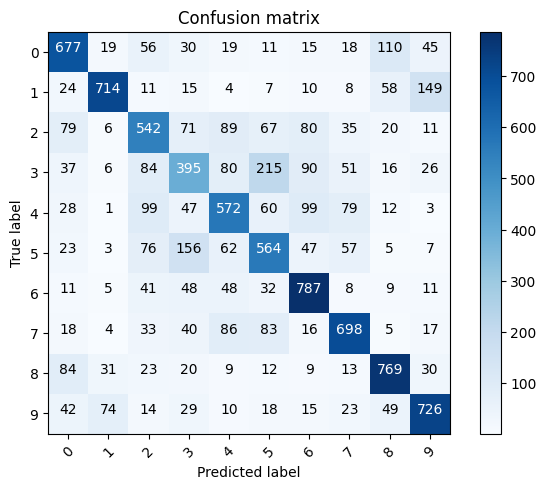

In [26]:
# get predictions in an array and plot the confusion matrix
x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
    # move data to device
    inputs = inputs.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # get predictions
    _, predictions = torch.max(outputs, 1)
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    # need to bring the result back to cpu to process the plot
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

## Apendix: Misclassified Cases
This covers examples of misclassification.

In [27]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

Text(0.5, 1.0, 'True label: bird Predicted: ship')

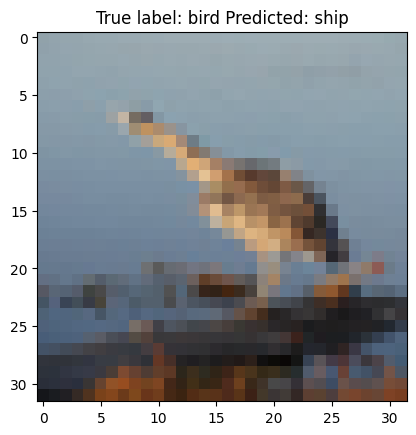

In [30]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32,32,3))
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]))